<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/10_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install umap-learn[plot] hdbscan kneed

In [ ]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml, load_iris
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import umap
import umap.plot as uplot

from kneed import KneeLocator

import hdbscan
from hdbscan.validity import validity_index

sns.set_theme()

### mnist dataset

In [ ]:
mnist = fetch_openml('mnist_784', parser='auto')

digits_data = mnist.data/255 # DataFrame
digit_labels = mnist.target

digit_labels_df = pd.DataFrame(digit_labels)
label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

<ipython-input-3-cd0e7a740970>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000)


Number of PCA components 784


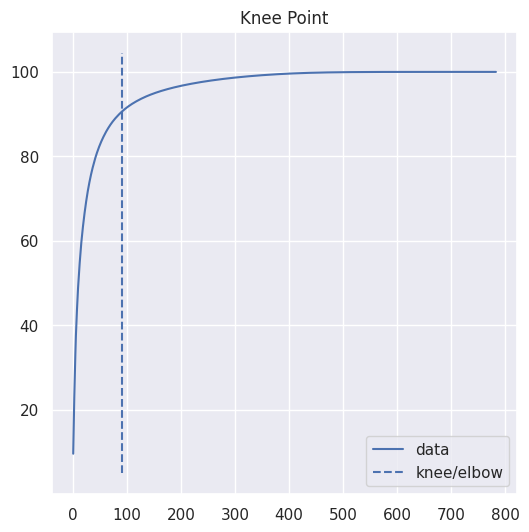

In [ ]:
pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()

In [ ]:
pca_dim_red = pca_transformed_data[:,:50]

<Axes: >

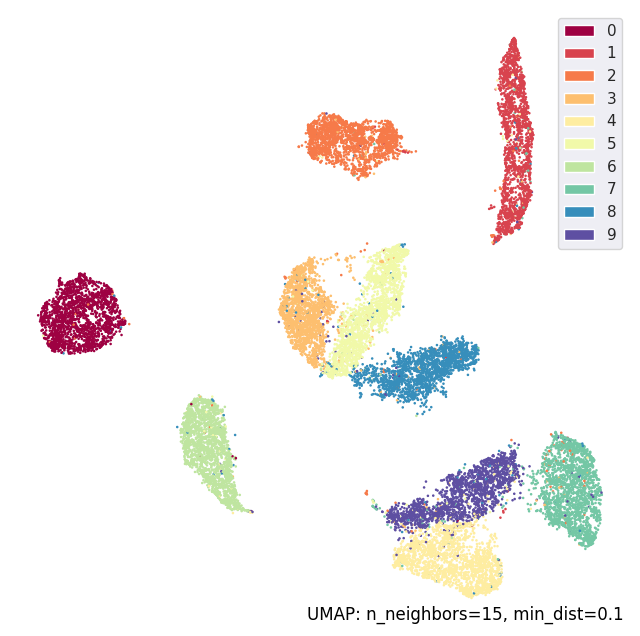

In [ ]:
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_dim_red)

uplot.points(umap_obj, labels=digit_labels)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

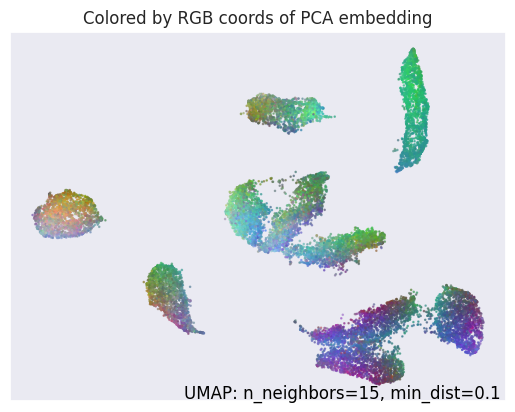

In [ ]:
umap.plot.diagnostic(umap_obj, diagnostic_type='pca')

### HDBSCAN

In [ ]:
def print_clustering_stats(clusterer, clust_data, data_labels, dbcv=False):
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    print('noise size : {}'.format(noise_size))
    if dbcv == True:
        print('DBCV : {}'.format(validity_index(clust_data, np_labels)))

ARI : 0.0620451604091957
ARI sub : 0.9949149740514572
noise size : 14873
DBCV : 0.0275406710127663


<Axes: >

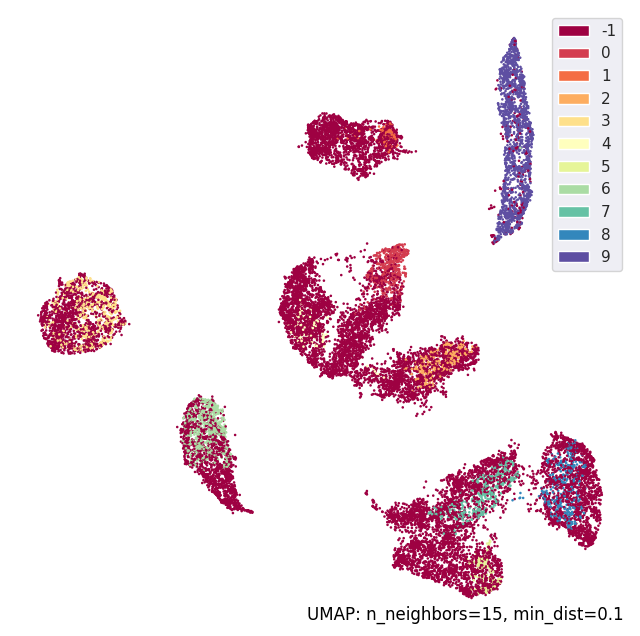

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    metric='euclidean'
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels,
    dbcv=True
)

uplot.points(umap_obj, labels=clusterer.labels_)

### DBCV

In [ ]:
def plot_distances(min_pts):
    knn = NearestNeighbors(n_neighbors=min_pts+1)
    knn.fit(pca_dim_red)
    distances, _ = knn.kneighbors(pca_dim_red)

    distances_min_pts = distances[:, -1]

    distances_by_label = {label: [] for label in np.unique(digit_labels)}
    for i, label in enumerate(digit_labels):
        distances_by_label[label].append(distances_min_pts[i])

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    fig.suptitle(f'min_pts: {min_pts}')
    for label, ax in zip(distances_by_label.keys(), axes.flatten()):
        sort_dist = np.sort(distances_by_label[label])
        ax.plot(range(sort_dist.shape[0]), sort_dist)

        ax.set_title(f'label {label}')
        ax.set_xlabel('index')
        ax.set_ylabel('distance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def run_dbcv(eps, min_pts):
    dbscan_tun = DBSCAN(eps=eps, min_samples=min_pts)
    _ = dbscan_tun.fit(pca_dim_red)

    print_clustering_stats(
        clusterer=dbscan_tun,
        clust_data=pca_dim_red,
        data_labels=digit_labels
    )

    uplot.points(umap_obj, labels=dbscan_tun.labels_)
    plt.title(f"eps: {eps}, min_pts: {min_pts}")  # 加入標題
    plt.show()
    return dbscan_tun

In [ ]:
def plot_dbcv_point_types(dbscan_tun):
    point_types = np.full(dbscan_tun.labels_.shape, "border point", dtype=object)

    point_types[dbscan_tun.labels_ == -1] = "noise point"
    point_types[dbscan_tun.core_sample_indices_] = "core point"

    uplot.points(umap_obj, labels=point_types)
    plt.title("DBSCAN Core, Border, and Noise Points")
    plt.show()

In [ ]:
min_pts = 50

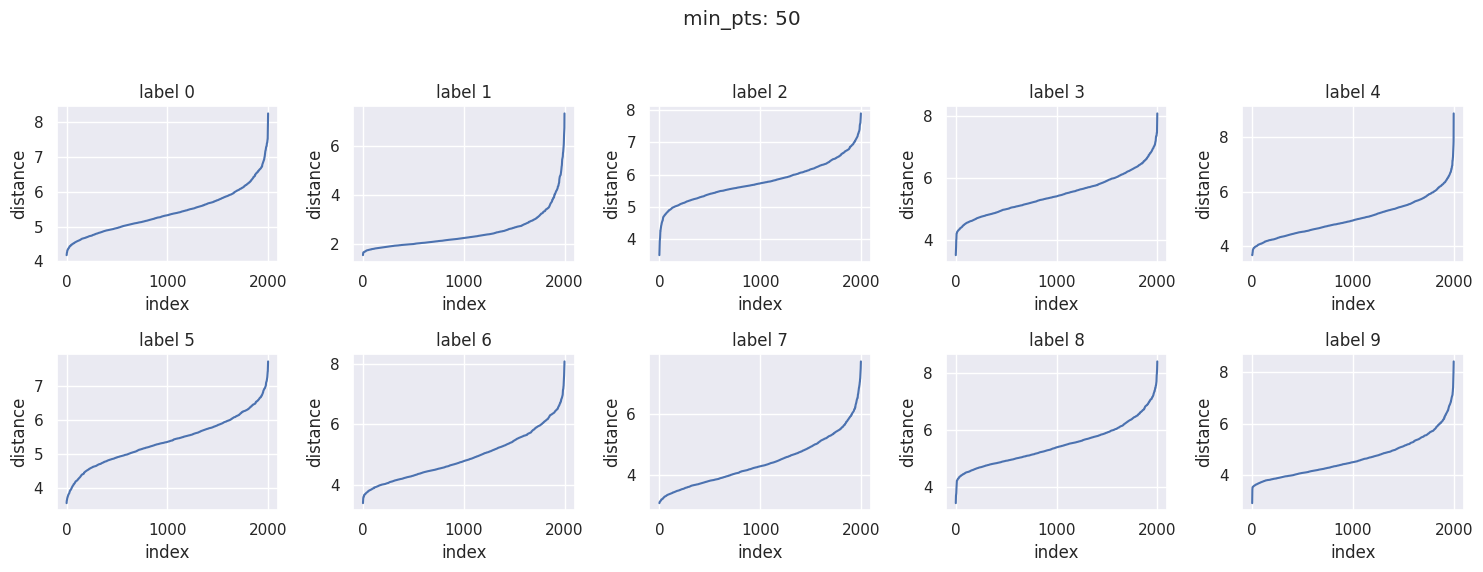

In [ ]:
plot_distances(min_pts)

In [ ]:
eps = 5

ARI : 0.015190023771268329
ARI sub : 0.0014102175332061382
noise size : 3629


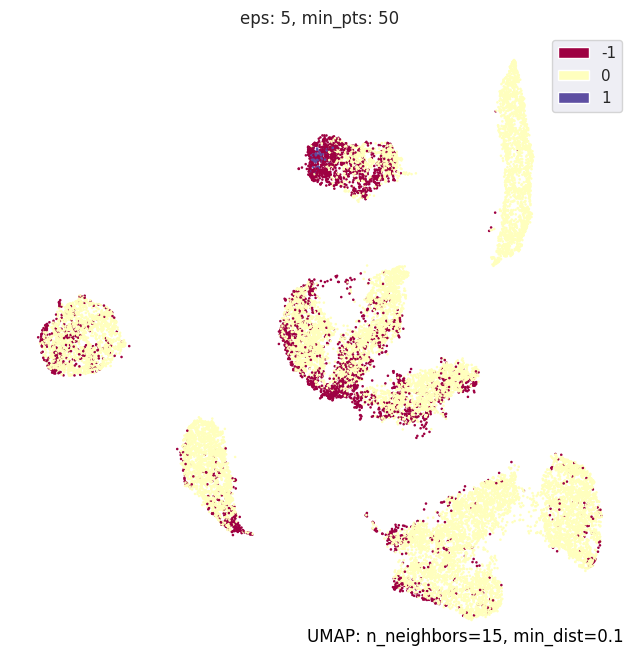

In [ ]:
dbscan_tun = run_dbcv(eps, min_pts)

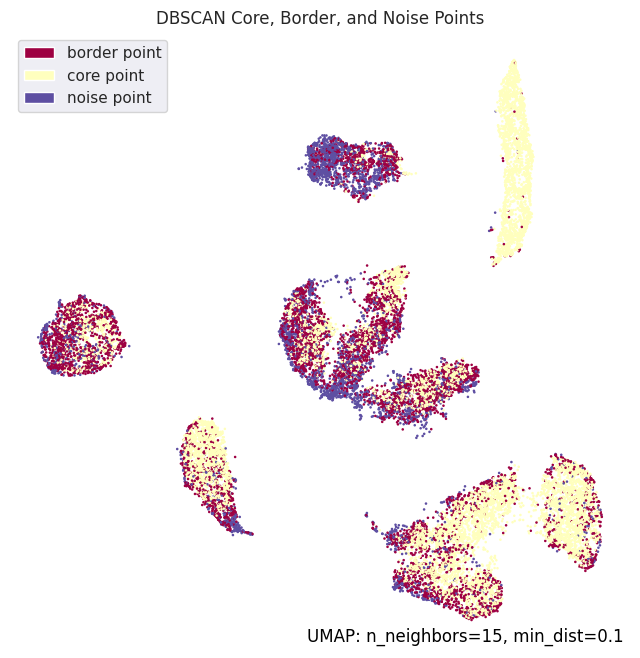

In [ ]:
plot_dbcv_point_types(dbscan_tun)

In [ ]:
min_pts = 3

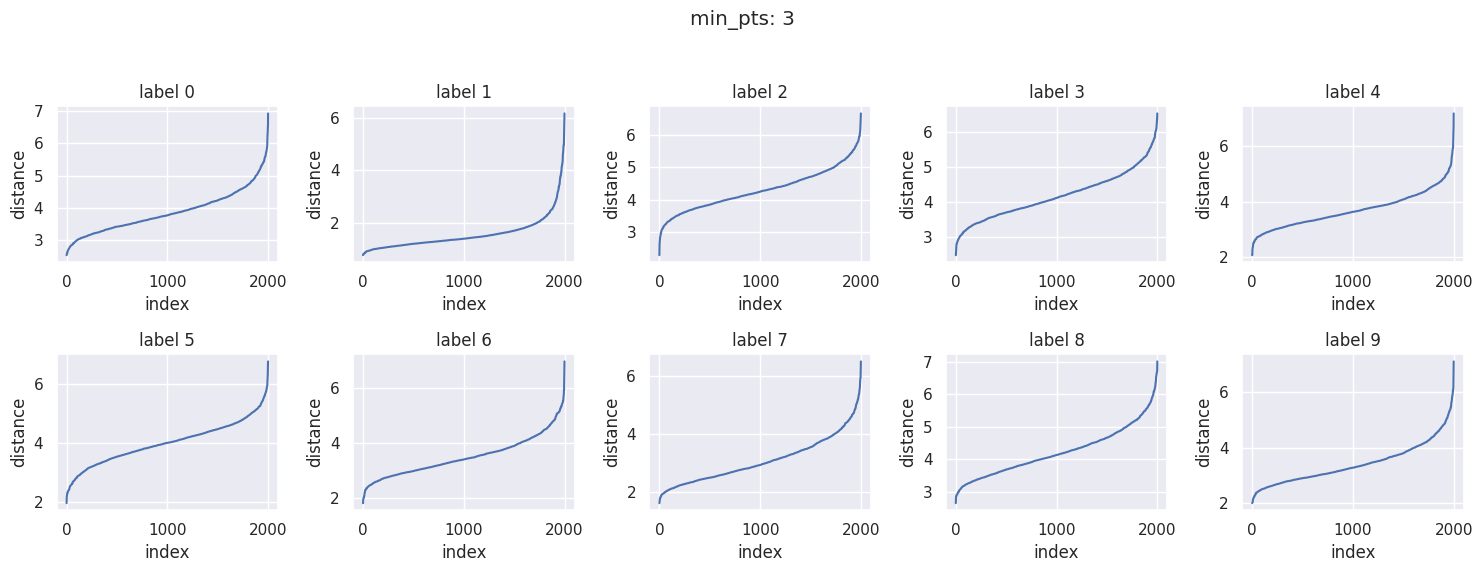

In [ ]:
plot_distances(min_pts)

In [ ]:
eps = 4

ARI : 0.013010891067727105
ARI sub : 0.0021300817001440723
noise size : 4084


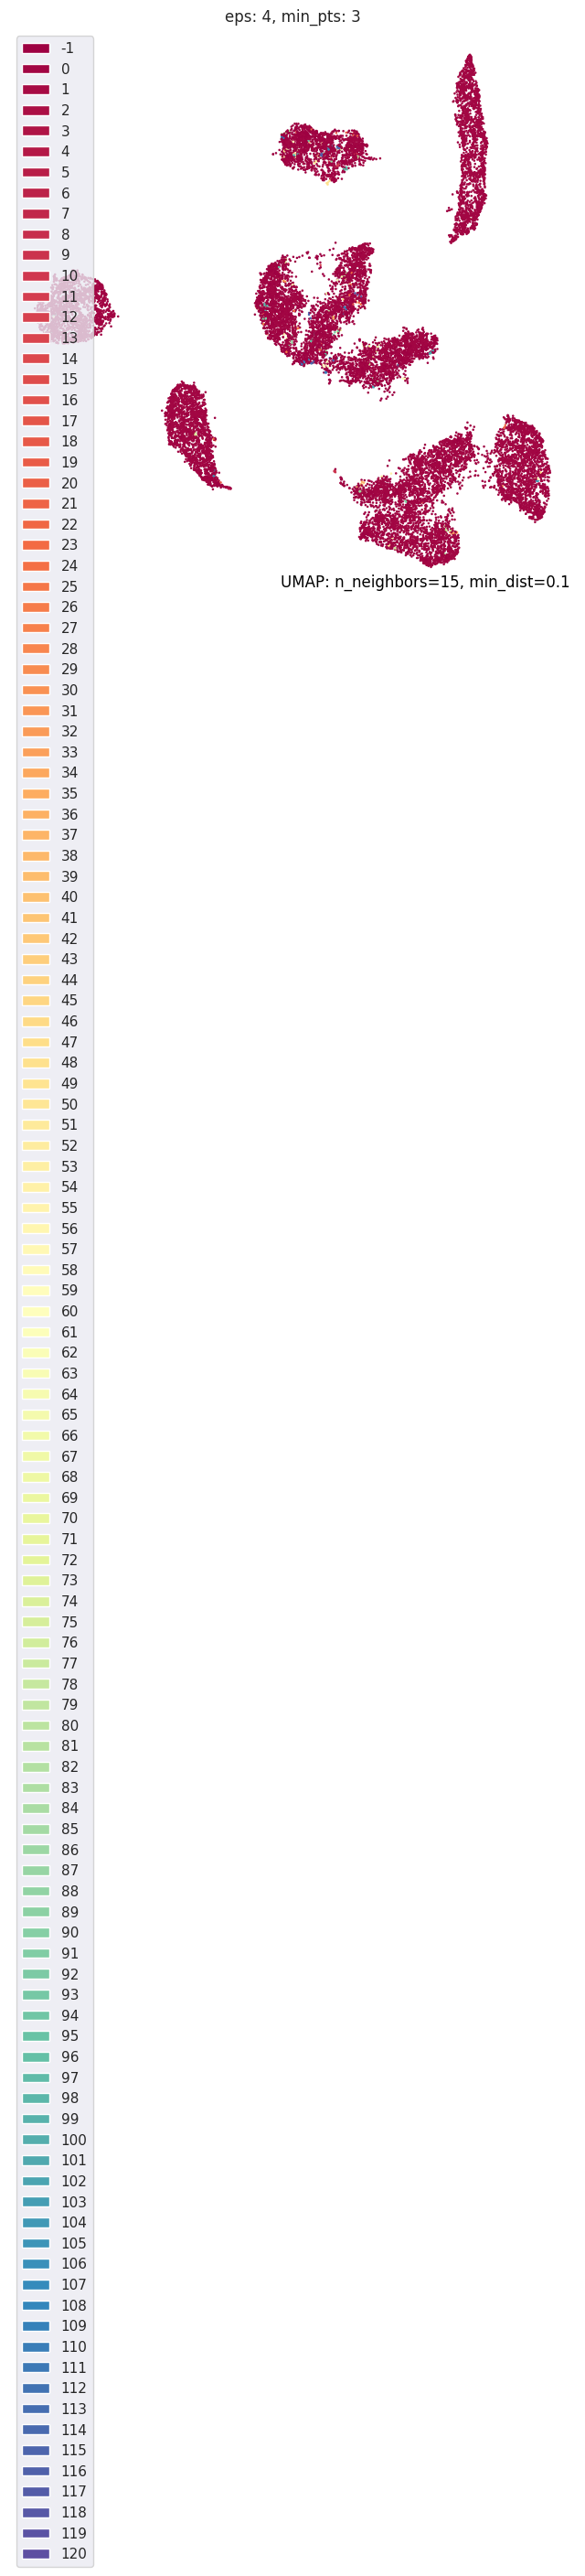

In [ ]:
dbscan_tun = run_dbcv(eps, min_pts)

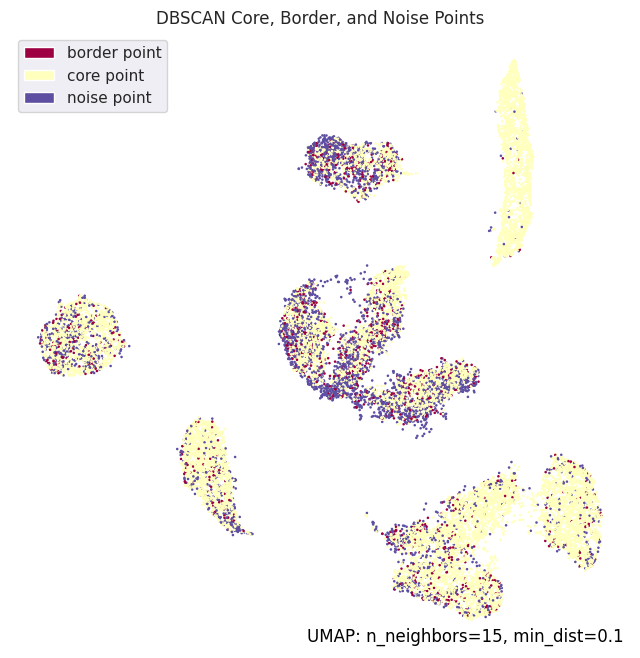

In [ ]:
plot_dbcv_point_types(dbscan_tun)